In [1]:
using thesis, PRMaps
using Healpix
using Plots
using Statistics
using LsqFit

import Stripeline as Sl
import Pandas as Pd

In [2]:
function run_scaling(
    tel_angles,
    sky_model::String,
    nside::Int
)
    
    strip = Pd.query(Pd.read_pickle("../instruments/lspe_strip_instrument.pkl"), :(frequency==43.0))
    signal = get_foreground_maps(strip, sky_model, nside)[1]

    camera = Sl.CameraAngles()
    obs_ideal, _ = makeIdealMapIQU(camera, signal, setup)
    
    obs_errored = PolarizedHealpixMap[]

    for i in tel_angles
        m, _ = makeErroredMapIQU(camera, i, signal, setup)
        push!(obs_errored, m)
    end

    error_i = [ (errored.i-obs_ideal.i) for errored in obs_errored]
    error_q = [ (errored.q-obs_ideal.q) for errored in obs_errored]
    error_u = [ (errored.u-obs_ideal.u) for errored in obs_errored]

    error_i_hist = [ i[isfinite.(i)] for i in error_i]
    error_q_hist = [ i[isfinite.(i)] for i in error_q]
    error_u_hist = [ i[isfinite.(i)] for i in error_u]

    std_error_i = [ std(i) for i in error_i_hist ]
    std_error_q = [ std(i) for i in error_q_hist ]
    std_error_u = [ std(i) for i in error_u_hist ]

    return (std_error_i, std_error_q, std_error_u)

end

run_scaling (generic function with 1 method)

In [3]:
nside = 512
sky_model = "c1s0d0"
obs_days = 5
 
setup = PRMaps.Setup(
    sampling_freq_Hz = 50.,
    total_time_s = 24. * 3600. * obs_days
    )
nothing

In [19]:
errored_angles_deg = [0.01, 10^-1.75, 10^-1.5, 10^-1.25, 10^-1.0, 10^-0.75, 10^-0.5]
omega_wobble_deg = [0.0, 90.0, 180.0, 270.0]

xdata = log10.(range(0.01, stop=maximum(errored_angles_deg), length=10000))

component = 2

nothing

In [42]:
xlabel = "Angle value [log10(degree)]"
ylabel = "std of the error distribution [log10(μK)]"

"std of the error distribution [log10(μK)]"

# Altitude offset angle

In [5]:
tel_angs_altitude = []
for i in errored_angles_deg
    push!(tel_angs_altitude, Sl.TelescopeAngles(wheel2ang_0_rad = deg2rad(i)))
end
result_altitude = run_scaling(tel_angs_altitude, sky_model, nside)
nothing

L'errore è fittato con la seguente funzione:

$\log\epsilon = p_1 \log^2 x + p_2 \log x + p_3$

con x l'angolo di non idealità.

In [34]:
@. model_linear(x,p) =  p[1]*x^2 + p[2]*x + p[3]

model_linear (generic function with 1 method)

In [35]:
log_error = log10.(result_altitude[component])
log_angle = log10.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)


[-0.20421445291839233, 0.3386051390926887, 0.8866042945944167]

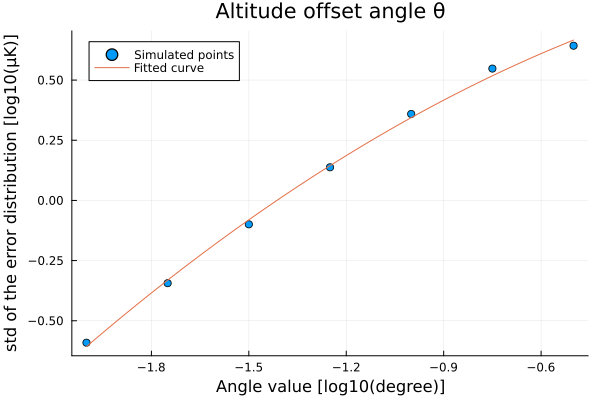

In [40]:
scatter(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fitted curve", title="Altitude offset angle θ")
#savefig("scaling/altitude.svg")

# Ground offset angle

In [9]:
tel_angs_ground = []
for i in errored_angles_deg
    push!(tel_angs_ground, Sl.TelescopeAngles(wheel3ang_0_rad = deg2rad(i)))
end
result_ground = run_scaling(tel_angs_ground, sky_model, nside)

([1.033684587112098, 1.837653480149115, 3.268040040845892, 5.822887371621012, 10.479018419797214, 19.159612913233023, 33.68943210167063], [0.07634746882147429, 0.13559621400150268, 0.2409397615023525, 0.4290845504025063, 0.7786779724667914, 1.4506909998831523, 2.513764324832887], [0.07189923891864212, 0.1278331839462321, 0.22748161927155688, 0.4063810121688153, 0.7382340819027721, 1.376294696080063, 2.4046733743468307])

In [10]:
log_error = log10.(result_ground[component])
log_angle = log10.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[0.012500074849606689, 1.0484921676919363, 0.9283518132694579]

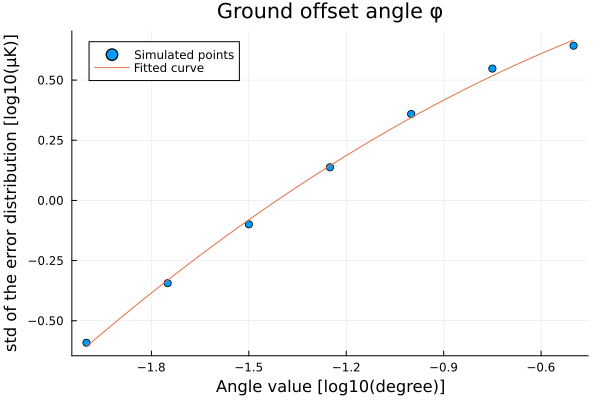

In [49]:
scatter(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fitted curve", title = "Ground offset angle φ")
#savefig("scaling/ground.svg")

# Fork angle

In [12]:
tel_angs_fork = []
for i in errored_angles_deg
    push!(tel_angs_fork, Sl.TelescopeAngles(forkang_rad = deg2rad(i)))
end
result_fork = run_scaling(tel_angs_fork, sky_model, nside)

([2.8376490047167016, 5.051476384268865, 9.058329761634477, 16.523538286697097, 29.62691059768335, 49.02012962912466, 72.76049088203919], [0.20960267723573142, 0.3728577637519822, 0.6718335895762125, 1.2480414610545818, 2.236897381408562, 3.4797061309131028, 4.330099626613869], [0.1975543991635751, 0.3523674867724316, 0.6360407988808114, 1.1809138418348177, 2.130509301742813, 3.2955214126730232, 4.181088536838182])

In [13]:
log_error = log10.(result_fork[component])
log_angle = log10.(errored_angles_deg)
fit_linear = curve_fit(model_linear, log_angle, log_error, [0.0, 0.5, 1.0])
print(fit_linear.param)

[-0.21450777244662955, 0.37911432498775194, 0.9118478524892601]

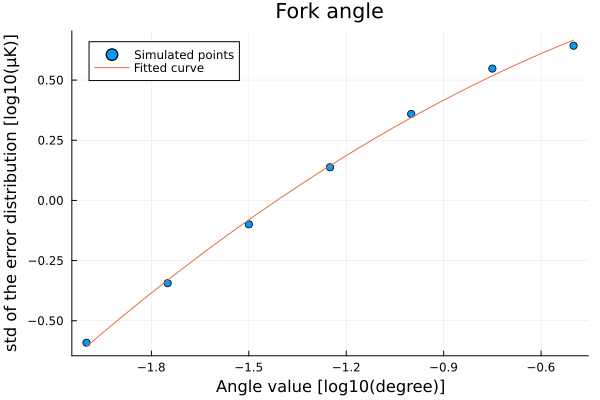

In [53]:
scatter(log_angle, log_error, xlabel=xlabel, ylabel=ylabel, label = "Simulated points")
plot!(xdata, model_linear(xdata, fit_linear.param), label = "Fitted curve", title = "Fork angle")

# Wobble angles

In [15]:
tel_angs_0 = []
tel_angs_90 = []
tel_angs_180 = []
tel_angs_270 = []

for i in errored_angles_deg
    push!(tel_angs_0, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(0.0)))
    push!(tel_angs_90, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(90.0)))
    push!(tel_angs_180, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(180.0)))
    push!(tel_angs_270, Sl.TelescopeAngles(zVAXang_rad = deg2rad(i), ωVAXang_rad = deg2rad(270.0)))
end

result_0 = run_scaling(tel_angs_0, sky_model, nside)
result_90 = run_scaling(tel_angs_90, sky_model, nside)
result_180 = run_scaling(tel_angs_180, sky_model, nside)
result_270 = run_scaling(tel_angs_270, sky_model, nside)

([0.0008126768526177044, 0.0025699093034456722, 0.008126766020013429, 0.025699080251596097, 0.0812647715699337, 0.2568921164564014, 0.8115233773086166], [6.448744527461137e-5, 0.0002039271893892601, 0.0006448743929106557, 0.0020392704099553875, 0.006446901006261175, 0.020369851864217296, 0.06427520496485715], [5.729457987238471e-5, 0.00018118126572497462, 0.0005729452591339786, 0.0018118092257030575, 0.005728758872902675, 0.018108302668864328, 0.05718963307126136])

In [16]:
log_angle = log10.(errored_angles_deg)

log_error_0 = log10.(result_0[component])
log_error_90 = log10.(result_90[component])
log_error_180 = log10.(result_180[component])
log_error_270 = log10.(result_270[component])

fit_linear_0 = curve_fit(model_linear, log_angle, log_error_0, [0.0, 1.0, 1.0])
fit_linear_90 = curve_fit(model_linear, log_angle, log_error_90, [0.0, 1.0, 1.0])
fit_linear_180 = curve_fit(model_linear, log_angle, log_error_180, [0.0, 1.0, 1.0])
fit_linear_270 = curve_fit(model_linear, log_angle, log_error_270, [0.0, 1.0, 1.0])

print(fit_linear_0.param)
print(fit_linear_90.param)
print(fit_linear_180.param)
print(fit_linear_270.param)

[-0.0002144038024724002, 1.9993477543796936, -0.37255464144180345][-0.00014411339346177856, 1.9983820665774024, -0.395872443376844][-0.00016375367592203594, 1.999516986647042, -0.3722009298808995][-0.0012922778110589354, 1.9959987679429099, -0.19347605823771288]

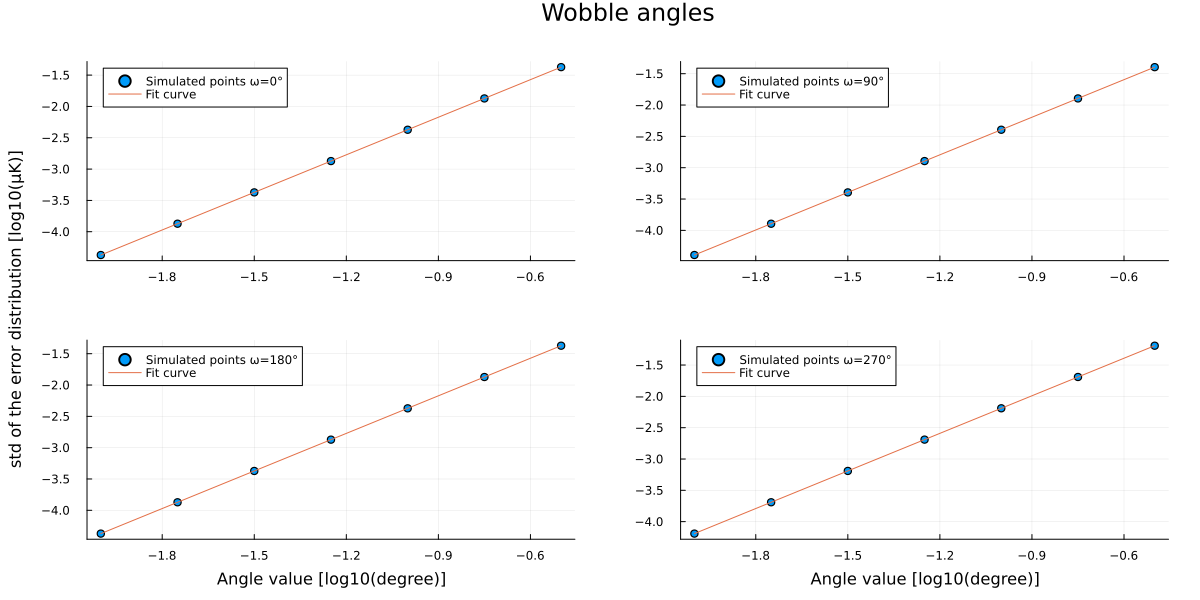

In [66]:

a = scatter(log_angle, log_error_0, ylabel=ylabel*"                                                         ", label = "Simulated points ω=0°")
a = plot!(xdata, model_linear(xdata, fit_linear_0.param), label = "Fit curve")

b = scatter(log_angle, log_error_90, label = "Simulated points ω=90°")
b = plot!(xdata, model_linear(xdata, fit_linear_90.param), label = "Fit curve")

c = scatter(log_angle, log_error_180, xlabel=xlabel, label = "Simulated points ω=180°")
c = plot!(xdata, model_linear(xdata, fit_linear_180.param), label = "Fit curve")

d = scatter(log_angle, log_error_270, xlabel=xlabel, label = "Simulated points ω=270°")
d = plot!(xdata, model_linear(xdata, fit_linear_270.param), label = "Fit curve")

plot(a,b,c,d, layaut = (4,1), size = (1200,600), margin = 6*Plots.mm, plot_title="Wobble angles")